In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import StratifiedKFold

# Functions


In [2]:
def compute_slope(df):
    '''
    Converts a longitudinal dataset to a cross-sectional dataset by taking the slope of the regression line between egfr and times.
    '''
    group_object = df.groupby(['ID'])
    grouped_data = [group_object.get_group(x) for x in group_object.groups]
    df_list = []
    for group in grouped_data:
        # Ignore patients with only 1 observation
        if len(group) == 1:
            continue
        ref = group.iloc[[0]]
        X = group['times'].to_numpy()
        y = group['egfr'].to_numpy()
        result = linregress(X, y)
        ref['slope'] = result.slope
        ref['r2'] = (result.rvalue)**2
        df_list.append(ref)
    df_new = pd.concat(df_list, ignore_index=True)
    df_new.drop(columns=['egfr', 'times'], inplace=True)

    return df_new

In [3]:
def create_response_variable(df, ref_df, top_percentile):
    p = np.percentile(ref_df['slope'], top_percentile)
    df['category'] = None
    for i in range(len(df)):
        if df.at[i, 'slope'] >= 0:
            df.at[i, 'category'] = 'Other'
        elif df.at[i, 'slope'] < p:
            df.at[i, 'category'] = 'Fast'
        else:
            df.at[i, 'category'] = 'Slow'

    return df, p

In [4]:
def create_response_variable_test(df, ref_df, p):
    df['category'] = None
    for i in range(len(df)):
        if df.at[i, 'slope'] >= 0:
            df.at[i, 'category'] = 'Other'
        elif df.at[i, 'slope'] < p:
            df.at[i, 'category'] = 'Fast'
        else:
            df.at[i, 'category'] = 'Slow'

    return df

In [5]:
def make_train_test_sets(train_df, test_df, top_percentile):
    train_df2 = compute_slope(train_df)
    test_df2 = compute_slope(test_df)

    train_df2_highr2 = train_df2.loc[train_df2['r2']>0.3].reset_index(drop=True)
    train_df2_highr2_negative_slope = train_df2.loc[(train_df2['slope']<0) & (train_df2['r2']>0.3)].reset_index(drop=True)
    train_df3, p = create_response_variable(train_df2_highr2, train_df2_highr2_negative_slope, top_percentile)

    test_df2_highr2 = test_df2.loc[test_df2['r2']>0.3].reset_index(drop=True)
    test_df2_highr2_negative_slope = test_df2.loc[(test_df2['slope']<0) & (test_df2['r2']>0.3)].reset_index(drop=True)
    test_df3 = create_response_variable_test(test_df2_highr2, test_df2_highr2_negative_slope, p)

    return train_df3, test_df3

# Checking that compute_slope works

In [ ]:
data_train_full = pd.read_csv('data_train_full.csv')
data_test = pd.read_csv('data_test.csv')

In [ ]:
print('Average number of observations per patient: ', data_train_full.groupby(['ID']).size().mean())

Average number of observations per patient:  7.932944606413995


In [ ]:
data_train_full2 = compute_slope(data_train_full)
data_train_full2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ID,site,age,gender,ethnicity,height,weight,smoker,kidney_transplant,patient_died,disease,bp.sys,bun,slope,r2
0,0,Sheffield,59.0,Male,Unknown,1.69,132.200000,Unknown,False,False,GMN,154.166667,8.000000,0.007620,0.304091
1,1,Sheffield,55.0,Female,Caucasian,1.60,72.000000,Unknown,True,True,Transplant,131.000000,8.000000,0.000112,0.000013
2,2,Sheffield,56.0,Male,Caucasian,1.73,67.050000,Unknown,True,False,Transplant,108.000000,12.000000,-0.003319,0.005842
3,3,Sheffield,43.0,Female,Caucasian,1.60,65.000000,Unknown,True,False,Transplant,135.000000,7.000000,0.000137,0.001187
4,4,Patras,60.0,Male,Caucasian,1.75,80.000000,Smoker,False,False,HTN,140.000000,81.000000,0.047937,0.537651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,1362,Patras,51.0,Male,Caucasian,1.70,98.000000,Smoker,False,False,DN,140.000000,78.000000,-0.006819,0.504592
1025,1363,Sheffield,46.0,Female,Caucasian,1.60,80.800000,Unknown,False,False,HTN,157.000000,37.581068,-0.007086,0.457036
1026,1364,Patras,37.0,Male,Caucasian,1.65,85.200000,Smoker,False,False,GMN,130.400000,45.000000,-0.001555,0.022376
1027,1365,Sheffield,66.0,Female,Caucasian,1.60,82.100000,Unknown,False,False,HTN,141.000000,8.000000,0.006822,0.682273


In [ ]:
data_test2 = compute_slope(data_test)
data_test2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ID,site,age,gender,ethnicity,height,weight,smoker,kidney_transplant,patient_died,disease,bp.sys,bun,slope,r2
0,6,Patras,67.0,Male,Caucasian,1.67,132.200000,Non-Smoker,False,False,DN,154.166667,88.000,-0.004610,0.234484
1,8,Sheffield,72.0,Male,Caucasian,1.73,72.000000,Unknown,False,False,HTN,160.000000,12.000,-0.000459,0.011017
2,13,Patras,41.0,Male,Caucasian,1.75,67.050000,Past-Smoker,True,False,Transplant,110.000000,52.000,-0.007852,0.557465
3,20,Sheffield,33.0,Male,Caucasian,1.73,65.000000,Unknown,True,False,Transplant,131.000000,9.000,0.190600,0.983071
4,28,Patras,71.0,Male,Caucasian,1.70,65.000000,Past-Smoker,False,False,DN,125.000000,74.000,-0.006625,0.167836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,1332,Sheffield,57.0,Male,Caucasian,1.73,96.766667,Unknown,True,False,Transplant,145.500000,12.000,-0.002271,0.049181
254,1343,Sheffield,47.0,Female,Caucasian,1.67,77.000000,Non-Smoker,False,False,DN,146.500000,99.375,-0.046445,0.317825
255,1344,Patras,65.0,Male,Caucasian,1.82,71.000000,Past-Smoker,False,False,HTN,125.714286,50.000,0.004748,0.246163
256,1345,Sheffield,63.0,Female,Caucasian,1.60,79.571429,Unknown,False,False,Vascular,125.357143,10.000,0.005080,0.246703


In [ ]:
data_train_full2.describe()

,ID,age,height,weight,bp.sys,bun,slope,r2
count,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000
mean,684.227405,55.258503,1.685294,81.791696,142.479340,30.904098,-0.002307,0.434427
std,395.167761,14.638419,0.078579,16.517250,17.325058,31.357647,0.139788,0.333306
min,0.000000,16.000000,1.410000,39.266667,95.000000,1.500000,-2.416667,0.000000
25%,342.000000,46.000000,1.600000,72.000000,131.500000,10.000000,-0.011530,0.113802
50%,683.000000,55.000000,1.690000,80.800000,140.000000,17.300000,-0.003177,0.399370
75%,1027.000000,66.000000,1.730000,89.250000,152.000000,39.000000,0.004220,0.721616
max,1366.000000,88.000000,2.020000,158.100000,208.000000,267.000000,3.666667,1.000000


# Visualise

In [ ]:
sns.set(style="ticks", font_scale=1.25)

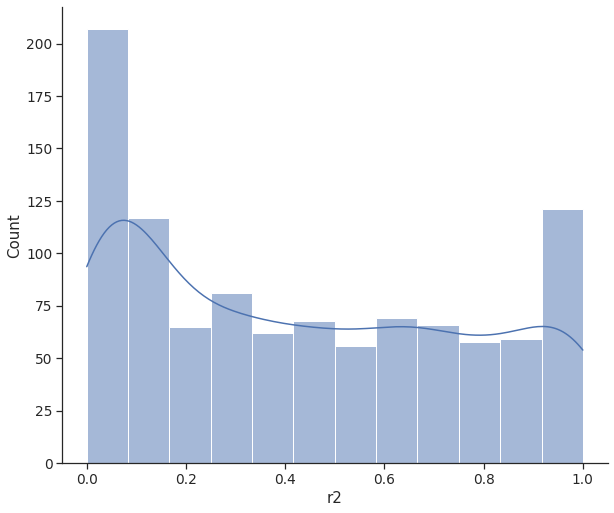

In [ ]:
# Distribution of R2 values
ax = sns.displot(data=data_train_full2, x='r2', kde=True)
ax.fig.set_size_inches(10, 8)

In [ ]:
data_train_full2_highr2 = data_train_full2.loc[data_train_full2['r2']>0.3]
high_r2_id_list = data_train_full2_highr2['ID'].to_numpy()

# Remaining patients after removing patients with R2 less than 0.3
print('Number of patients with R2 greater than 0.3: ', len(high_r2_id_list))

Number of patients with R2 greater than 0.3:  587


In [ ]:
# Separate patients with positive and negative slopes
data_train_full2_positive_slope = data_train_full2.loc[(data_train_full2['slope']>=0) & (data_train_full2['r2']>0.3)]
data_train_full2_negative_slope = data_train_full2.loc[(data_train_full2['slope']<0) & (data_train_full2['r2']>0.3)]
high_r2_positive_slope_id_list = data_train_full2_positive_slope['ID'].to_numpy()
high_r2_negative_slope_id_list = data_train_full2_negative_slope['ID'].to_numpy()

print('Number of patients with R2 greater than 0.3 and positive slope: ', len(high_r2_positive_slope_id_list))
print('Number of patients with R2 greater than 0.3 and negative slope: ', len(high_r2_negative_slope_id_list))

Number of patients with R2 greater than 0.3 and positive slope:  182
Number of patients with R2 greater than 0.3 and negative slope:  405


In [ ]:
data_train_full_highr2 = data_train_full[data_train_full['ID'].isin(high_r2_id_list)]
data_train_full_highr2_positive_slope = data_train_full[data_train_full['ID'].isin(high_r2_positive_slope_id_list)]
data_train_full_highr2_negative_slope = data_train_full[data_train_full['ID'].isin(high_r2_negative_slope_id_list)]

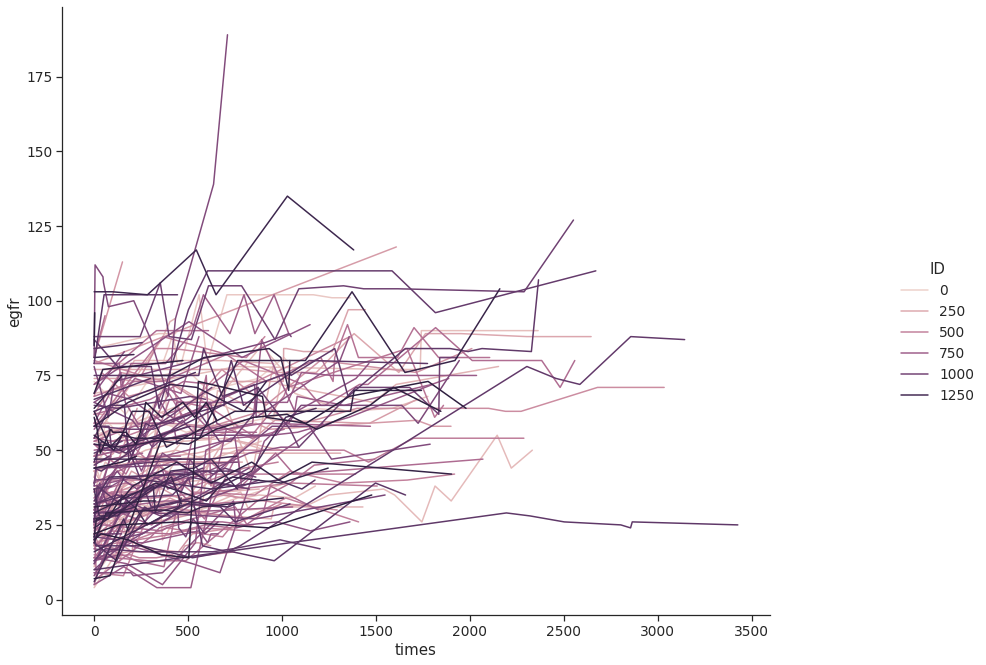

In [ ]:
# Patients with positive slopes and R2 > 0.3
ax = sns.relplot(x='times', y='egfr', hue='ID', data=data_train_full_highr2_positive_slope, kind='line')
ax.fig.set_size_inches(15, 10)

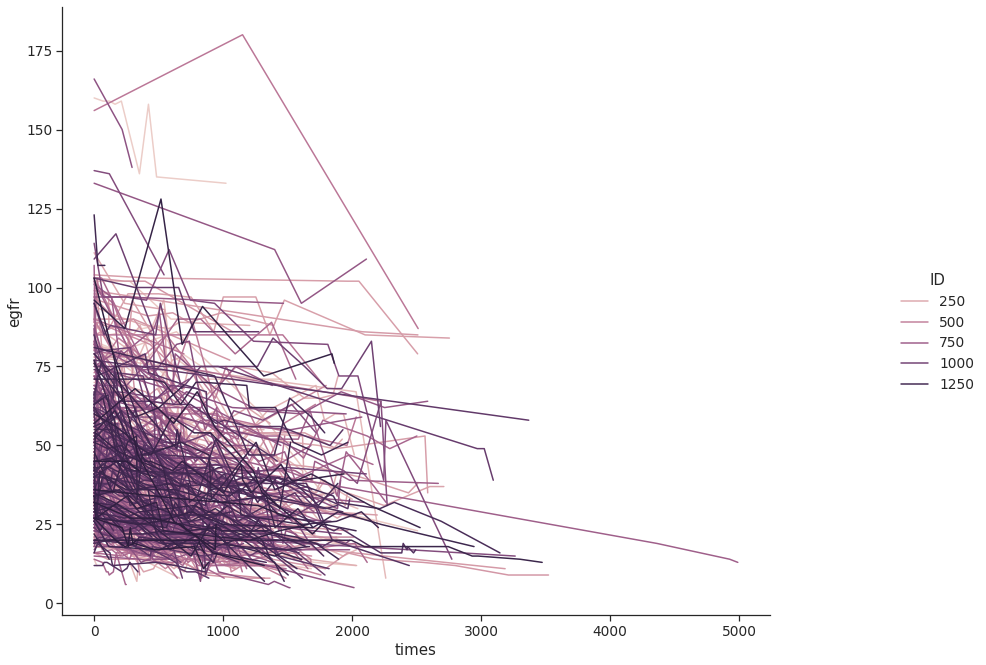

In [ ]:
# Patients with negative slopes and R2 > 0.3
ax = sns.relplot(x='times', y='egfr', hue='ID', data=data_train_full_highr2_negative_slope, kind='line')
ax.fig.set_size_inches(15, 10)

# Create categorical variable for slope

Classify patients according to:
- Fast deterioration
- Slow deterioration
- Other (improvement)

Fast deterioration patients are those in the top 25th percentile of patients with a negative slope. We repeat this process with top 10th and top 50th percentile later.

In [ ]:
data_train_full2_highr2.reset_index(inplace=True, drop=True)
data_train_full2_highr2

,ID,site,age,gender,ethnicity,height,weight,smoker,kidney_transplant,patient_died,disease,bp.sys,bun,slope,r2
0,0,Sheffield,59.0,Male,Unknown,1.69,132.200000,Unknown,False,False,GMN,154.166667,8.000000,0.007620,0.304091
1,4,Patras,60.0,Male,Caucasian,1.75,80.000000,Smoker,False,False,HTN,140.000000,81.000000,0.047937,0.537651
2,7,Sheffield,75.0,Female,Unknown,1.69,66.000000,Unknown,False,False,GMN,158.500000,11.000000,0.036181,0.643511
3,9,Sheffield,75.0,Male,Caucasian,1.73,100.600000,Unknown,False,False,HTN,140.000000,12.000000,-0.008929,1.000000
4,14,Sheffield,66.0,Male,Caucasian,1.73,66.400000,Smoker,False,False,Other,153.666667,9.000000,-0.009849,0.660132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,1361,Sheffield,64.0,Female,Caucasian,1.60,59.525000,Unknown,False,False,GMN,155.000000,6.000000,-0.079660,0.849428
583,1362,Patras,51.0,Male,Caucasian,1.70,98.000000,Smoker,False,False,DN,140.000000,78.000000,-0.006819,0.504592
584,1363,Sheffield,46.0,Female,Caucasian,1.60,80.800000,Unknown,False,False,HTN,157.000000,37.581068,-0.007086,0.457036
585,1365,Sheffield,66.0,Female,Caucasian,1.60,82.100000,Unknown,False,False,HTN,141.000000,8.000000,0.006822,0.682273


In [ ]:
data_train_full3, p = create_response_variable(data_train_full2_highr2, data_train_full2_negative_slope, 25)
data_train_full3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ID,site,age,gender,ethnicity,height,weight,smoker,kidney_transplant,patient_died,disease,bp.sys,bun,slope,r2,category
0,0,Sheffield,59.0,Male,Unknown,1.69,132.200000,Unknown,False,False,GMN,154.166667,8.000000,0.007620,0.304091,Other
1,4,Patras,60.0,Male,Caucasian,1.75,80.000000,Smoker,False,False,HTN,140.000000,81.000000,0.047937,0.537651,Other
2,7,Sheffield,75.0,Female,Unknown,1.69,66.000000,Unknown,False,False,GMN,158.500000,11.000000,0.036181,0.643511,Other
3,9,Sheffield,75.0,Male,Caucasian,1.73,100.600000,Unknown,False,False,HTN,140.000000,12.000000,-0.008929,1.000000,Slow
4,14,Sheffield,66.0,Male,Caucasian,1.73,66.400000,Smoker,False,False,Other,153.666667,9.000000,-0.009849,0.660132,Slow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,1361,Sheffield,64.0,Female,Caucasian,1.60,59.525000,Unknown,False,False,GMN,155.000000,6.000000,-0.079660,0.849428,Fast
583,1362,Patras,51.0,Male,Caucasian,1.70,98.000000,Smoker,False,False,DN,140.000000,78.000000,-0.006819,0.504592,Slow
584,1363,Sheffield,46.0,Female,Caucasian,1.60,80.800000,Unknown,False,False,HTN,157.000000,37.581068,-0.007086,0.457036,Slow
585,1365,Sheffield,66.0,Female,Caucasian,1.60,82.100000,Unknown,False,False,HTN,141.000000,8.000000,0.006822,0.682273,Other


In [ ]:
p

-0.022184480926076975

In [ ]:
data_train_full3.groupby(['category']).size()

category
Fast     101
Other    182
Slow     304
dtype: int64

In [ ]:
data_train_full3_y = data_train_full3[['ID', 'category']]
data_train_full_highr2_new = pd.merge(left=data_train_full_highr2, right=data_train_full3_y, how='left', on=['ID'])

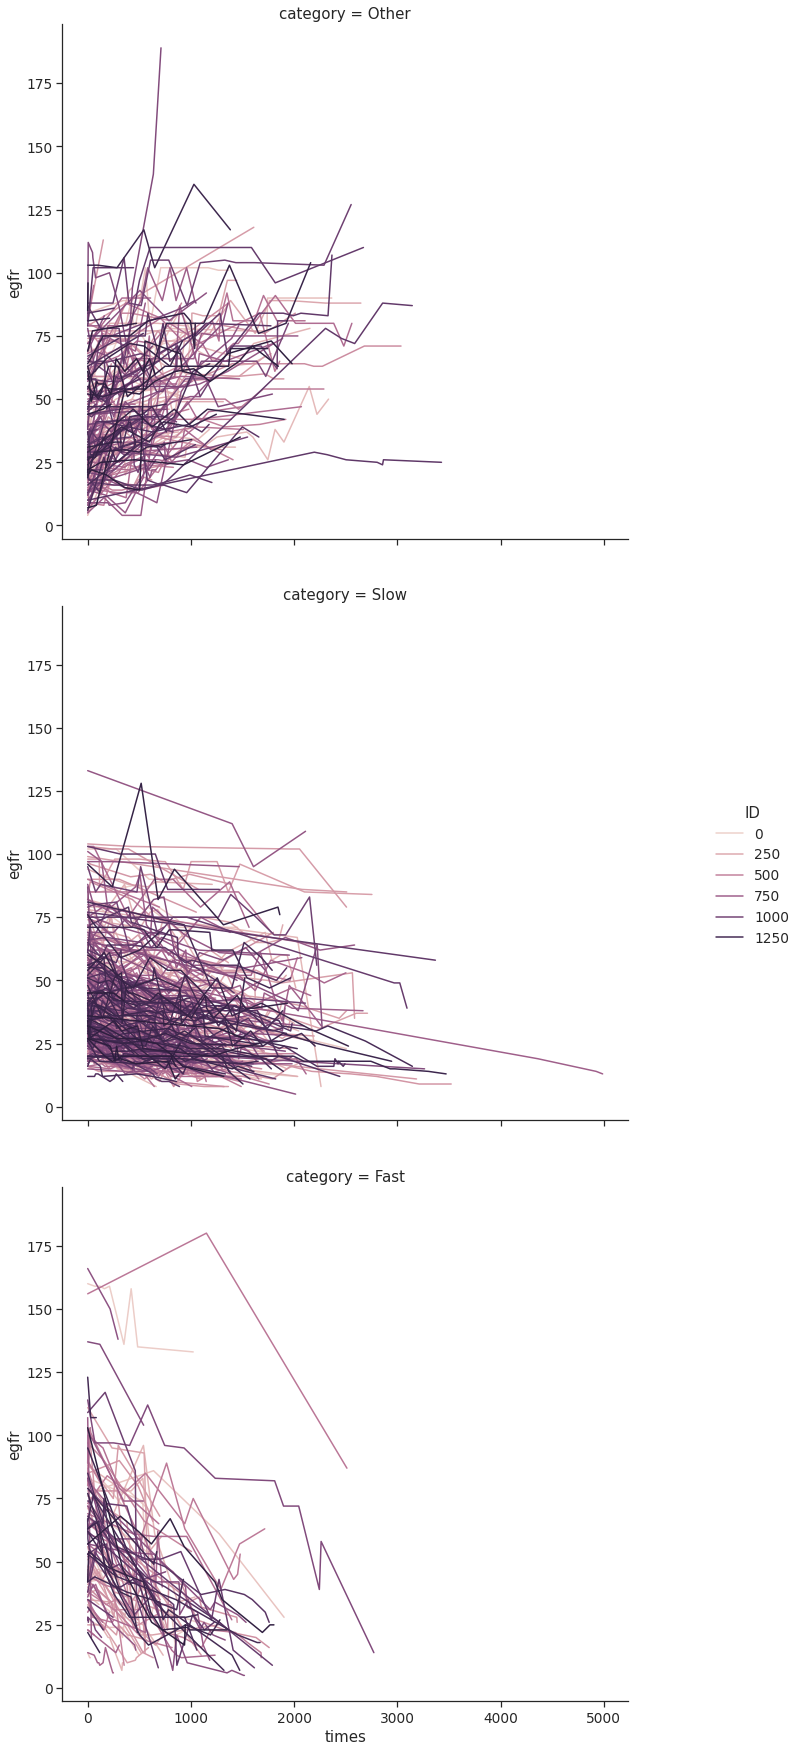

In [ ]:
# Visualise egfr progression across categories
ax = sns.relplot(x='times', y='egfr', hue='ID', row='category', data=data_train_full_highr2_new, kind='line')
ax.fig.set_size_inches(12, 25)

# Get 5-fold CV splits using stratified K-fold

In [6]:
!unzip file.zip
data_train_full = pd.read_csv('content/data/data_train_full.csv')
data_test = pd.read_csv('content/data/data_test.csv')

n
Archive:  file.zip
replace content/data/data_train_full.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace content/data/data_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: content/data/data_test.csv  


In [12]:
data_train_full_new, data_test_new = make_train_test_sets(data_train_full, data_test, top_percentile=25)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
# Make CV sets
# Get the ID numbers of patients in each split
kfold = StratifiedKFold(n_splits=5)
train_set_list, val_set_list = [], []
for train_index, val_index in kfold.split(data_train_full_new, data_train_full_new['category']):
    train_set_list.append(data_train_full_new.iloc[train_index]['ID'].reset_index(drop=True))
    val_set_list.append(data_train_full_new.iloc[val_index]['ID'].reset_index(drop=True))

In [14]:
for i in range(5):
    train_set_list[i].to_csv('data/train_set_ids_'+str(i+1)+'.csv', index=False)
    val_set_list[i].to_csv('data/val_set_ids_'+str(i+1)+'.csv', index=False)

In [15]:
!zip -r /content/file.zip /content/data

  adding: content/data/ (stored 0%)
  adding: content/data/train_set_ids_2.csv (deflated 53%)
  adding: content/data/val_set_ids_2.csv (deflated 54%)
  adding: content/data/val_set_ids_1.csv (deflated 50%)
  adding: content/data/val_set_ids_4.csv (deflated 56%)
  adding: content/data/val_set_ids_3.csv (deflated 54%)
  adding: content/data/train_set_ids_1.csv (deflated 55%)
  adding: content/data/train_set_ids_4.csv (deflated 52%)
  adding: content/data/train_set_ids_3.csv (deflated 53%)
  adding: content/data/train_set_ids_5.csv (deflated 51%)
  adding: content/data/val_set_ids_5.csv (deflated 62%)


# Convert all datasets

In [6]:
!unzip file.zip
data_train_full = pd.read_csv('content/data/data_train_full.csv')
data_test = pd.read_csv('content/data/data_test.csv')

Archive:  file.zip
   creating: content/data/
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_train_full.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_train_5.csv  
   creating: content/data/.ipynb_checkpoints/
  inflating: content/data/data_test.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_cv_train_3.csv  


In [7]:
data_cv_train_list = []
data_cv_val_list = []
for i in range(5):
    data_cv_train_list.append(pd.read_csv('content/data/data_cv_train_' + str(i+1) + '.csv'))
    data_cv_val_list.append(pd.read_csv('content/data/data_cv_val_' + str(i+1) + '.csv'))

In [ ]:
data_cv_train_new_list = []
data_cv_val_new_list = []
for i in range(5):
    train_new, val_new = make_train_test_sets(data_cv_train_list[i], data_cv_val_list[i], top_percentile=50)
    data_cv_train_new_list.append(train_new)
    data_cv_val_new_list.append(val_new)

In [ ]:
data_train_full_new, data_test_new = make_train_test_sets(data_train_full, data_test, top_percentile=50)

In [10]:
data_train_full_new.to_csv('data/data_train_full_new.csv', index=False)
data_test_new.to_csv('data/data_test_new.csv', index=False)
for i in range(5):
    data_cv_train_new_list[i].to_csv('data/data_cv_train_new_' + str(i+1) + '.csv', index=False)
    data_cv_val_new_list[i].to_csv('data/data_cv_val_new_' + str(i+1) + '.csv', index=False)

In [11]:
!zip -r /content/file.zip /content/data

  adding: content/data/ (stored 0%)
  adding: content/data/data_cv_train_new_3.csv (deflated 71%)
  adding: content/data/data_cv_train_new_4.csv (deflated 71%)
  adding: content/data/data_cv_val_new_4.csv (deflated 69%)
  adding: content/data/data_train_full_new.csv (deflated 72%)
  adding: content/data/data_test_new.csv (deflated 69%)
  adding: content/data/data_cv_train_new_5.csv (deflated 71%)
  adding: content/data/data_cv_train_new_2.csv (deflated 71%)
  adding: content/data/data_cv_val_new_1.csv (deflated 70%)
  adding: content/data/data_cv_val_new_3.csv (deflated 69%)
  adding: content/data/data_cv_val_new_5.csv (deflated 69%)
  adding: content/data/data_cv_val_new_2.csv (deflated 69%)
  adding: content/data/data_cv_train_new_1.csv (deflated 71%)
